In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [31]:
data0 = pd.read_csv('./BTC_10m_active_3m_6m.csv')

data0['datetime'] = pd.to_datetime(data0['datetime'])
data0 = data0.set_index('datetime')

data0

,active_3m_6m
datetime,
2021-01-01 00:00:00,1.196062e+06
2021-01-01 00:10:00,1.196180e+06
2021-01-01 00:20:00,1.196373e+06
2021-01-01 00:30:00,1.196389e+06
2021-01-01 00:40:00,1.196370e+06
...,...
2025-06-07 23:10:00,1.852014e+06
2025-06-07 23:20:00,1.852208e+06
2025-06-07 23:30:00,1.852225e+06


In [32]:
df = data0.copy()

df_half_hourly = df.resample('30min').mean()

df_hourly = df.resample('1h').mean()

df_daily = df.resample('1D').mean()

df_weekly = df.resample('1W').mean()

## Stationary Check

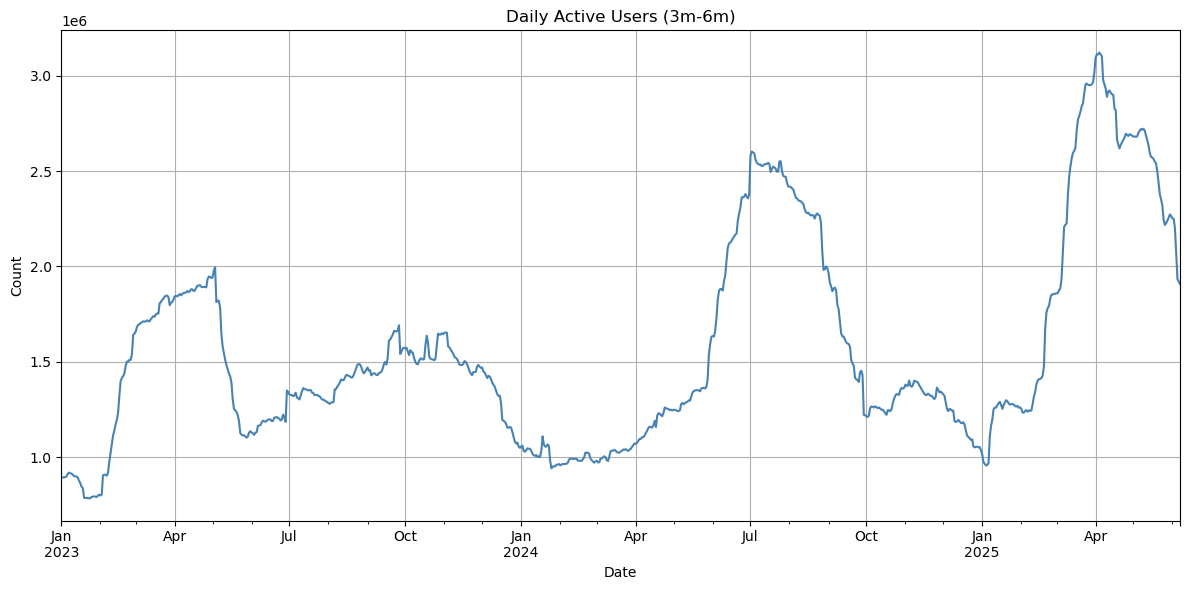

In [33]:
df_2023_onward_daily = df_daily.loc['2023-01-01':]

# plot
df_2023_onward_daily['active_3m_6m'].plot(
    figsize=(12, 6),
    title='Daily Active Users (3m-6m)',
    xlabel='Date',
    ylabel='Count',
    grid=True,
    color='steelblue'
)
plt.tight_layout()
plt.show()

In [34]:
y = df_2023_onward_daily['active_3m_6m'].dropna()
n = len(y)
n_train = int(n * 0.8)
y_train = y[:n_train]
y_val = y[n_train:]

In [35]:
adf_p = adfuller(y_train)[1]
print(f"ADF p-value before diff: {adf_p:.4f}")

y_train_diff = y_train.diff().dropna()
adf_p = adfuller(y_train_diff)[1]
print(f"ADF p-value after diff: {adf_p:.4f}")

y_train_diff2 = y_train_diff.diff().dropna()
adf_p = adfuller(y_train_diff2)[1]
print(f"ADF p-value after second diff: {adf_p:.4f}")

ADF p-value before diff: 0.0301
ADF p-value after diff: 0.0001
ADF p-value after second diff: 0.0000


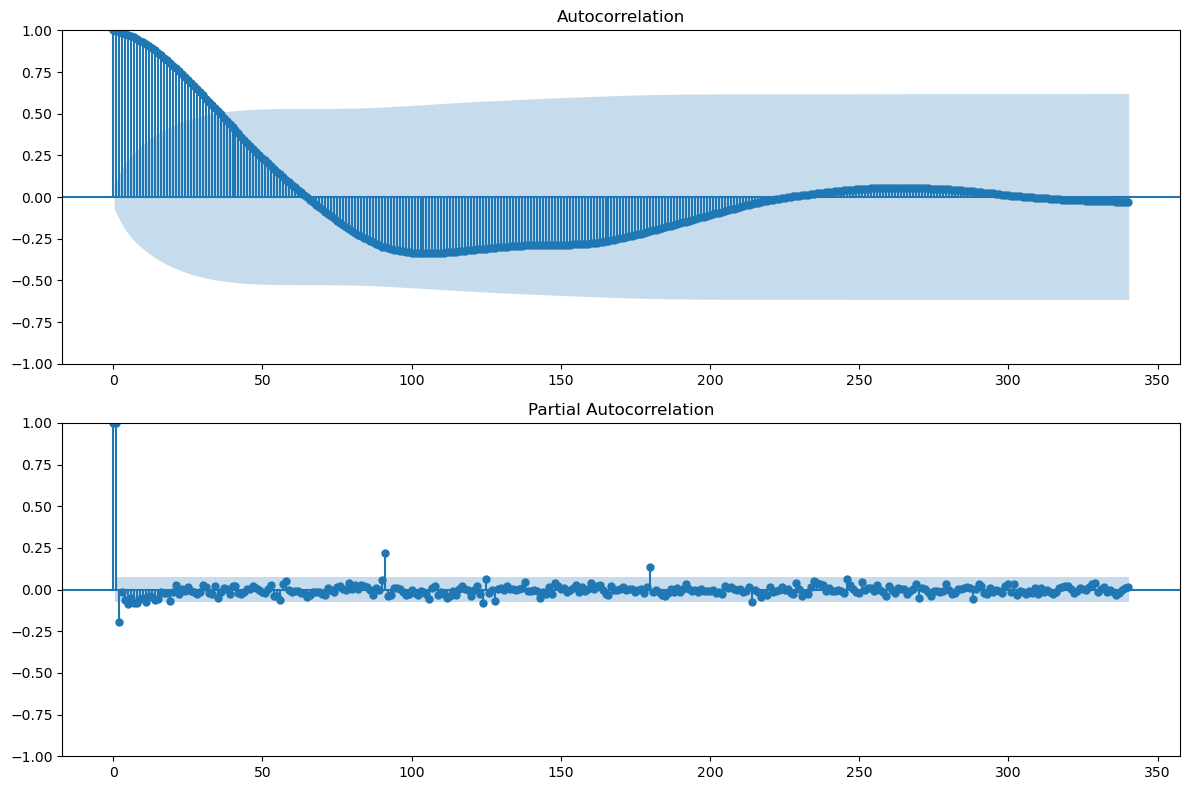

In [36]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(y_train, lags=340, ax=ax[0])
plot_pacf(y_train, lags=340, ax=ax[1])
plt.tight_layout()
plt.show()

## Train

In [37]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


y = df_2023_onward_daily['active_3m_6m'].dropna()

n = len(y)
n_train = int(n * 0.8)
y_train = y[:n_train]
y_test = y[n_train:]

print(f"data presplit done: training={len(y_train)}, testing={len(y_test)}")


def mase(y_true, y_pred, y_train):
    """Mean Absolute Scaled Error"""
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_train.diff().dropna()))
    return mae_model / mae_naive if mae_naive != 0 else np.nan

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error (original definition)"""
    return np.mean(np.abs((y_true - y_pred) / y_true))

def compute_metrics(y_true, y_pred, y_train):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))
    mape_val = mape(y_true, y_pred)
    mase_val = mase(y_true, y_pred, y_train)
    return rmse, mae, mape_val, mase_val

def fast_forecast(y_train, y_test, order):
    model = ARIMA(y_train, order=order)
    fitted = model.fit()
    
    start = len(y_train)
    end = len(y_train) + len(y_test) - 1
    y_pred = fitted.predict(start=start, end=end, dynamic=True)
    
    return y_pred, fitted.aic, fitted.bic

results = []
p_range = range(0, 5)    # p = 0,1,2,3,4,5
d_range = [0]         # d = 0,1,2
q_range = range(0, 5)    # q = 0,1,2,3,4,5

total = len(p_range) * len(d_range) * len(q_range)

for p in tqdm(p_range, desc="p loop"):
    for d in d_range:
        for q in q_range:
            try:
                if p == 0 and q == 0:
                    continue

                # prediction
                y_pred, aic, bic = fast_forecast(y_train, y_test, order=(p, d, q))
                rmse, mae, mape_val, mase_val = compute_metrics(y_test, y_pred, y_train)

                results.append({
                    'p': p, 'd': d, 'q': q,
                    'AIC': aic,
                    'BIC': bic,
                    'AIC_BIC_mean': (aic + bic) / 2,
                    'RMSE': rmse,
                    'MAE': mae,
                    'MAPE': mape_val,
                    'MASE': mase_val
                })
                
            except Exception as e:
                continue

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('AIC').reset_index(drop=True)

print("\n" + "="*80)
print("top 10 ARIMA model results sorted by AIC:")
print("="*80)
print(results_df[['p','d','q','RMSE','MAE','MAPE','MASE','AIC','BIC', 'AIC_BIC_mean']].head(10).to_string(index=False))

best = results_df.iloc[0]
print(f"\nBest Model: ARIMA({best['p']}, {best['d']}, {best['q']})")
print(f"   AIC = {best['AIC']:.4f}")

data presplit done: training=711, testing=178


p loop: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


top 10 ARIMA model results sorted by AIC:
 p  d  q         RMSE           MAE     MAPE      MASE          AIC          BIC  AIC_BIC_mean
 4  0  1 8.460577e+05 647393.543082 0.259800 42.897685 16466.928267 16498.894974  16482.911620
 2  0  4 8.894601e+05 679452.642725 0.272561 45.021990 16469.658663 16506.192042  16487.925353
 3  0  2 8.553527e+05 654811.024524 0.262367 43.389184 16491.896649 16523.863356  16507.880002
 4  0  3 8.580855e+05 656892.158856 0.263061 43.527084 16496.827587 16537.927639  16517.377613
 4  0  0 9.877875e+05 762243.116110 0.307598 50.507865 16509.643659 16537.043693  16523.343676
 4  0  2 1.015834e+06 787101.162457 0.318252 52.155012 16511.417205 16547.950585  16529.683895
 2  0  0 1.011409e+06 783071.070268 0.316531 51.887970 16511.810929 16530.077619  16520.944274
 1  0  4 1.003517e+06 776034.204404 0.313473 51.421692 16512.402018 16544.368725  16528.385371
 3  0  0 1.011485e+06 783139.758735 0.316563 51.892521 16513.811355 16536.644717  16525.228036
 2  0  

## Check Model Prediction Plot

training: 2023-01-01 00:00:00 → 2024-12-11 00:00:00
testing: 2024-12-12 00:00:00 → 2025-06-07 00:00:00


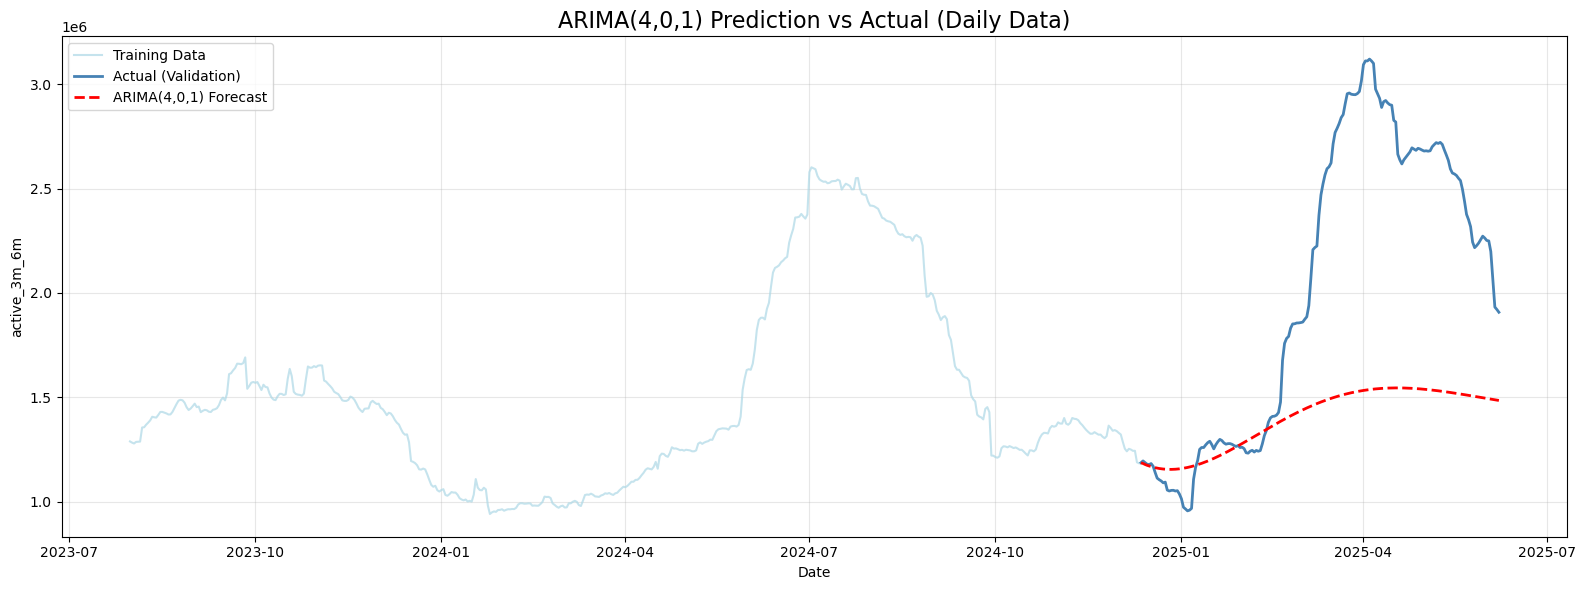

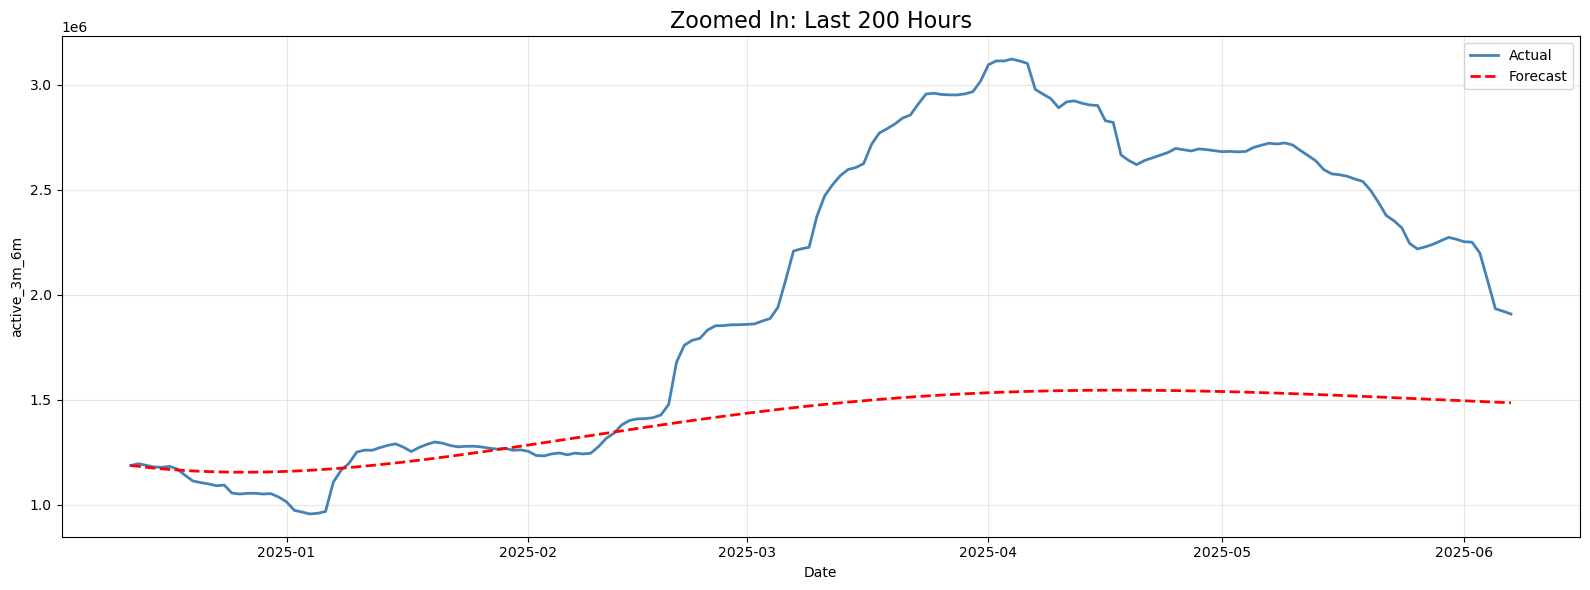

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

y = df_2023_onward_daily['active_3m_6m'].dropna()

# train/test
n_train = int(len(y) * 0.8)
y_train = y[:n_train]
y_test = y[n_train:]

print(f"training: {y_train.index[0]} → {y_train.index[-1]}")
print(f"testing: {y_test.index[0]} → {y_test.index[-1]}")

model = ARIMA(y_train, order=(4, 0, 1))
fitted_model = model.fit()

start = len(y_train)
end = len(y_train) + len(y_test) - 1
y_pred = fitted_model.predict(start=start, end=end, dynamic=True, typ='levels')

plt.figure(figsize=(16, 6))

plt.plot(y_train.index[-500:], y_train[-500:], 
         color='lightblue', alpha=0.7, label='Training Data')

plt.plot(y_val.index, y_val, 
         color='steelblue', linewidth=2, label='Actual (Validation)')

plt.plot(y_val.index, y_pred, 
         color='red', linestyle='--', linewidth=2, label='ARIMA(4,0,1) Forecast')

plt.title('ARIMA(4,0,1) Prediction vs Actual (Daily Data)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('active_3m_6m')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
# last 200 hours
n_show = min(200, len(y_val))
plt.plot(y_val.index[-n_show:], y_val[-n_show:], 
         color='steelblue', linewidth=2, label='Actual')
plt.plot(y_val.index[-n_show:], y_pred[-n_show:], 
         color='red', linestyle='--', linewidth=2, label='Forecast')
plt.title('Zoomed In: Last 200 Hours', fontsize=16)
plt.xlabel('Date')
plt.ylabel('active_3m_6m')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

___